In [1]:
import numpy, struct, sys
import matplotlib.pyplot as plt

In [2]:
## Load  a trace data set from an on-disk file.
##
## \param[in] f the filename to load  trace data set from
## \return    t the number of traces
## \return    s the number of samples in each trace
## \return    M a t-by-16 matrix of AES-128  plaintexts
## \return    C a t-by-16 matrix of AES-128 ciphertexts
## \return    T a t-by-s  matrix of samples, i.e., the traces

def traces_ld( f ) :
  fd = open( f, "rb" )

  def rd( x ) :
    ( r, ) = struct.unpack( x, fd.read( struct.calcsize( x ) ) ) ; return r

  t = rd( '<I' )
  s = rd( '<I' )

  M = numpy.zeros( ( t, 16 ), dtype = numpy.uint8 )
  C = numpy.zeros( ( t, 16 ), dtype = numpy.uint8 )
  T = numpy.zeros( ( t,  s ), dtype = numpy.int16 )

  for i in range( t ) :
    for j in range( 16 ) :
      M[ i, j ] = rd( '<B' )

  for i in range( t ) :
    for j in range( 16 ) :
      C[ i, j ] = rd( '<B' )

  for i in range( t ) :
    for j in range( s  ) :
      T[ i, j ] = rd( '<h' )

  fd.close()

  return t, s, M, C, T

## Store a trace data set into an on-disk file.
##
## \param[in] f the filename to store trace data set into
## \param[in] t the number of traces
## \param[in] s the number of samples in each trace
## \param[in] M a t-by-16 matrix of AES-128  plaintexts
## \param[in] C a t-by-16 matrix of AES-128 ciphertexts
## \param[in] T a t-by-s  matrix of samples, i.e., the traces

def traces_st( f, t, s, M, C, T ) :
  fd = open( f, "wb" )

  def wr( x, y ) :
    fd.write( struct.pack( x, y ) )

  wr( '<I', t,  )
  wr( '<I', s,  )

  for i in range( t ) :
    for j in range( 16 ) :
      wr( '<B', M[ i, j ] )

  for i in range( t ) :
    for j in range( 16 ) :
      wr( '<B', C[ i, j ] )

  for i in range( t ) :
    for j in range( s  ) :
      wr( '<h', T[ i, j ] )

  fd.close()

In [3]:
sbox = [0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
        0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
        0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
        0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
        0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
        0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
        0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
        0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
        0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
        0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
        0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
        0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
        0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
        0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
        0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
        0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16]

In [4]:
hamming_weights = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4,
                   1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                   1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                   2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                   1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                   2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                   2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                   3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                   1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                   2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                   2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                   3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                   2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                   3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                   3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                   4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

In [5]:
t, s, M, C, T = traces_ld("../../../dan-traces.dat")

In [22]:
t = 200   # Only using 250 traces
s = 10000 # Only using first 10000 samples

V = numpy.zeros((t, 256), dtype = numpy.uint8) # Hypothetical intermediate values
H = numpy.zeros((t, 256), dtype = numpy.uint8) # Hypothetical power consumption values

In [23]:
for i in range(t):
    for j in range(256):
        V[i,j] = sbox[M[i,0] ^ j]
        H[i,j] = hamming_weights[V[i,j]]

In [24]:
max_correlation = 0
byte = 0

for i in range(256):
    for j in range(s):
        correlation = numpy.abs(numpy.corrcoef(H[:,i], T[0:t,j])[0][1])
        if (correlation > max_correlation):
            max_correlation = correlation
            byte = i
        
print(max_correlation)
print(byte)

0.49158740640732734
212


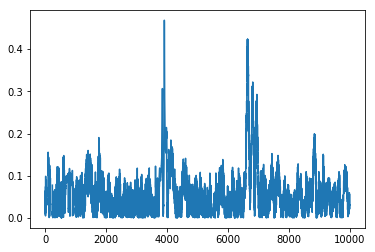

In [25]:
fig, ax = plt.subplots()
ax.plot(R[byte,:])
plt.show()